### Figure 4: QQ plot

In [1]:
import numpy as np
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import xesmf as xe
from utils.data import load_tc_data
# sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
# TODO: check x and y axes obs vs preds

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def radMask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius

  return mask

In [3]:
model = ''
# set mode
mode = 'validation'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)

# load datasets
real,inputs,pred,meta = load_tc_data(set='validation',results='ke_tracks')
real_2,inputs_2,pred_2,meta_2,inputs_og,pred_og,meta_og = load_tc_data(set='validation',results='kh_tracks')
meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/valid_meta.csv')

meta_valid = pd.read_csv('/user/work/al18709/tc_data_flipped/valid_meta.csv')
print(pred.shape)
print(inputs.shape)
print(real.shape)

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
# inputs_hr = regridder(inputs)
# inputs_hr_x = regridder(inputs_x)
# hrmip_hr = regridder(hrmip)


(15930, 10, 10)
(15930, 100, 100, 20)
(15930, 10, 10, 6)
(15930, 100, 100, 1)


/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [4]:
precip_clevs = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
import matplotlib
import seaborn as sns
import metpy
from matplotlib.colors import LinearSegmentedColormap
import metpy.plots.ctables
precip_cmap = matplotlib.colors.ListedColormap(metpy.plots.ctables.colortables["precipitation"][:len(precip_clevs)-1], 'precipitation')
precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N)

tc_colours = [(255/255,255/255,255/255), # no rain
			(169/255, 209/255, 222/255), # drizzle 0-1
			(137/255, 190/255, 214/255), # drizzle 1-2
			(105/255, 160/255, 194/255), # drizzle 2-3
			(93/255, 168/255, 98/255), # drizzle 3-5
			(128/255, 189/255, 100/255), # very light rain 5-7
			(165/255, 196/255, 134/255), # light rain 7-10
			(233/255, 245/255, 105/255), # rain 10-15
			(245/255, 191/255, 105/255), # heavy rain 15-20
			(245/255, 112/255, 105/255), # heavier rain 20-25
			(245/255, 105/255, 149/255), # real heavy rain 25-30
			(240/255, 93/255, 154/255), # intense rain 30-40
			(194/255, 89/255, 188/255), # super intense rain 40-50
			(66/255, 57/255, 230/255), # insane amount of rain 50-70
			(24/255, 17/255, 153/255), # you do not want to be caught in this rain 70-100
			(9/255, 5/255, 87/255), # I can't belive the scle goes up this high 100-150
]
# if high_vals == False:
# 	N = 16
# else:
N=16
precip_cmap = LinearSegmentedColormap.from_list('tc_colours',tc_colours,N=N) #increasing N makes it smoother
precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N)

In [5]:
# # y = np.load('/user/work/al18709/tc_data_mswep/valid_y.npy')
# x = np.load('/user/work/al18709/tc_data_mswep/extreme_test_X.npy')
# y = np.load('/user/work/al18709/tc_data_mswep/extreme_test_y.npy')

# # print(np.argpartition(np.max(np.max(x,axis=1),axis=1),-10)[-10:])
# print([np.max(np.max(x,axis=1),axis=1)[j] for j in np.argpartition(np.max(np.max(x,axis=1),axis=1),-10)[-10:]])

# # print(np.argpartition(np.max(np.max(y,axis=1),axis=1),-10)[-10:])
# print([np.max(np.max(y,axis=1),axis=1)[j] for j in np.argpartition(np.max(np.max(y,axis=1),axis=1),-10)[-10:]])

In [6]:
def calc_ensemble_percentile(ensemble,analysis,percentiles):
	ensemble_p=np.zeros((1,len(percentiles)))
	print(ensemble.shape)
	for i in range(1):
		if analysis == 'Mean' or analysis == 'Mean | extremes':
			p = np.percentile(np.mean(np.mean(ensemble[:,:,:,i],axis=1),axis=1), percentiles)
		elif analysis == 'Peak' or analysis == 'Peak | extremes':
			p = np.percentile(np.max(np.max(ensemble[:,:,:,i],axis=1),axis=1), percentiles)
		elif analysis == 'Total' or analysis == 'Total | extremes':
			p = np.percentile(np.sum(np.sum(ensemble[:,:,:,i],axis=1),axis=1), percentiles)
		elif analysis == 'Core' or analysis == 'Core | extremes':
			mask=radMask((25,25),25,ensemble[0,:,:,0])
			n,_,_,_ = ensemble.shape
			mask = np.expand_dims(mask,axis=0)
			mask = np.repeat(mask,n,axis=0)
			p = np.percentile(np.ma.array(ensemble[:,:,:,i], mask=mask), percentiles)
		ensemble_p[i] = p
	ensemble_mean = np.mean(ensemble_p,axis=0)
	ensemble_std = np.std(ensemble_p,axis=0)
	ensemble_min = np.min(ensemble_p,axis=0)
	ensemble_max = np.max(ensemble_p,axis=0)
	return ensemble_mean,ensemble_min,ensemble_max

		

In [7]:
# # take only top 100 extremes
# inputs_x_max = np.max(inputs_x,axis=(1,2))
# max_idx = list(np.argpartition(inputs_x_max, -100)[-100:])

# # redefine extremes by only the most extreme samples
# inputs_hr_x = inputs_hr_x[max_idx]
# pred_cnn_x = pred_cnn_x[max_idx]
# pred_vaegan_x = pred_vaegan_x[max_idx]
# pred_gan_x = pred_gan_x[max_idx]
# real_x = real_x[max_idx]
# pred_vaegan_ensemble_x = pred_vaegan_ensemble_x[max_idx]
# pred_gan_ensemble_x = pred_gan_ensemble_x[max_idx]

# print(pred_gan_ensemble_x.shape)
# print(real_x.shape)


In [8]:

def plot_qq(ax,analysis,pred,pred_2,pred_og,real,cnn=False):
	percentiles = np.arange(0,100,0.01)

	if analysis == 'Mean' or analysis == 'Mean | extremes':
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred,analysis,percentiles)
		pred2_p,pred2_min,pred2_max = calc_ensemble_percentile(pred_2,analysis,percentiles)
		predog_p,predog_min,predog_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
		real_p = np.percentile(np.mean(np.mean(real,axis=1),axis=1), percentiles)

	elif analysis == 'Peak' or analysis == 'Peak | extremes':
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred,analysis,percentiles)
		pred2_p,pred2_min,pred2_max = calc_ensemble_percentile(pred_2,analysis,percentiles)
		predog_p,predog_min,predog_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
		real_p = np.percentile(np.max(np.max(real,axis=1),axis=1), percentiles)

	elif analysis == 'Total' or analysis == 'Total | extremes':
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred,analysis,percentiles)
		pred2_p,pred2_min,pred2_max = calc_ensemble_percentile(pred_2,analysis,percentiles)
		predog_p,predog_min,predog_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
		real_p = np.percentile(np.sum(np.sum(real,axis=1),axis=1), percentiles)

	elif analysis == 'Core' or analysis == 'Core | extremes':
		mask=radMask((25,25),25,real[0,:,:,0])
		n,_,_,_ = real.shape
		mask = np.expand_dims(mask,axis=0)
		mask = np.repeat(mask,n,axis=0)
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred,analysis,percentiles)
		pred2_p,pred2_min,pred2_max = calc_ensemble_percentile(pred_2,analysis,percentiles)
		predog_p,predog_min,predog_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
		real_p = np.percentile(np.ma.array(real, mask=mask), percentiles)
	
	ax.scatter(real_p,dsrnngan_p,color='#729ea1')
	ax.scatter(real_p,pred2_p,color='Green')
	ax.scatter(real_p,predog_p,color='Pink')

	x_y = np.arange(0,1500,1)
	ax.plot(x_y,x_y,'--',color='black')
	if analysis == 'Mean':
		ax.legend(['WGAN_1D','WGAN_2D','WGAN_OG'],frameon=False,fontsize=16)
	ax.fill_between(real_p, dsrnngan_min, dsrnngan_max,color='#729ea1',alpha=0.2)
	ax.fill_between(real_p, pred2_min, pred2_max,color='Green',alpha=0.2)
	ax.fill_between(real_p, predog_min, predog_max,color='Pink',alpha=0.2)
	ax.set_xlabel('Observed rain (mm / h)',fontsize=18)
	ax.set_ylabel('Predicted rain (mm / h)',fontsize=18)
	ax.set_title(analysis,fontsize=18,fontweight='bold')
	ax.tick_params(axis='both', which='major', labelsize=14)
	if analysis == 'Mean | extremes':
		ax.set_ylim([0,20])
		ax.set_xlim([0,20])
		ax.set_yticks([0,5,10,15,20])
	elif analysis == 'Peak | extremes':
		ax.set_ylim([0,750])
		ax.set_xlim([0,750])
		ax.set_xticks([0,100,200,300,400,500,600,700])
	elif analysis == 'Core | extremes':
		ax.set_ylim([0,300])
		ax.set_xlim([0,300])
	elif analysis == 'Mean':
		ax.set_ylim([0,20])
		ax.set_xlim([0,20])
	elif analysis == 'Peak':
		ax.set_ylim([0,400])
		ax.set_xlim([0,400])
	elif analysis == 'Core':
		ax.set_ylim([0,150])
		ax.set_xlim([0,150])
		ax.set_xticks([0,10,20,30,40,50,60,70])

	print(analysis)
	return ax



(15930, 100, 100, 20)
(15930, 100, 100, 20)
(16253, 100, 100, 20)
Mean
(15930, 100, 100, 20)
(15930, 100, 100, 20)
(16253, 100, 100, 20)
Peak
(15930, 100, 100, 20)
(15930, 100, 100, 20)
(16253, 100, 100, 20)
Core


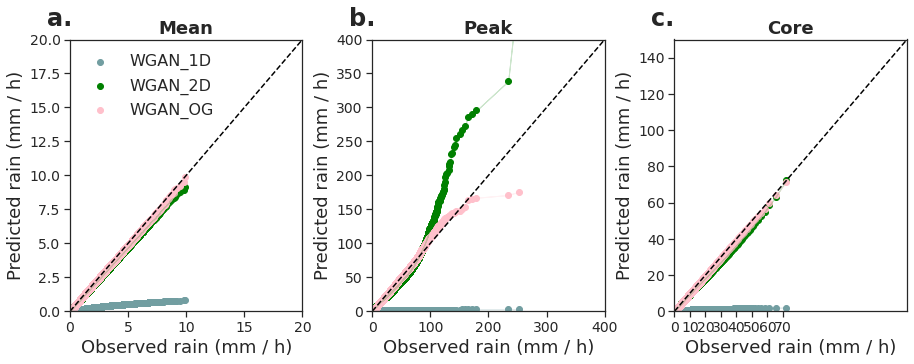

In [9]:

# plt.style.use('ticks')
sns.set_style("ticks")
sns.set_context("notebook")
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
ax1 = plot_qq(axes[0],'Mean',pred,pred_2,pred_og,real)
ax2 = plot_qq(axes[1],'Peak',pred,pred_2,pred_og,real)
# ax3 = plot_qq(axes[0,2],'Total',inputs_hr,real)
ax4 = plot_qq(axes[2],'Core',pred,pred_2,pred_og,real)
# ax5 = plot_qq(axes[1,0],'Mean | extremes',inputs_hr_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x)
# ax6 = plot_qq(axes[1,1],'Peak | extremes',inputs_hr_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x)
# # ax7 = plot_qq(axes[1,2],'Total (extremes)',inputs_hr_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x)
# ax8 = plot_qq(axes[1,2],'Core | extremes',inputs_hr_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,cnn=True)



axes[0].text(-0.1, 1.05, 'a.', transform=axes[0].transAxes, size=24, weight='bold')
axes[1].text(-0.1, 1.05, 'b.', transform=axes[1].transAxes, size=24, weight='bold')
axes[2].text(-0.1, 1.05, 'c.', transform=axes[2].transAxes, size=24, weight='bold')
# axes[0,3].text(-0.1, 1.05, 'd.', transform=axes[0,3].transAxes, size=28, weight='bold')
# axes[1,0].text(-0.1, 1.05, 'd.', transform=axes[1,0].transAxes, size=24, weight='bold')
# axes[1,1].text(-0.1, 1.05, 'e.', transform=axes[1,1].transAxes, size=24, weight='bold')
# axes[1,2].text(-0.1, 1.05, 'f.', transform=axes[1,2].transAxes, size=24, weight='bold')
# axes[1,3].text(-0.1, 1.05, 'e.', transform=axes[1,3].transAxes, size=28, weight='bold')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.35)
plt.savefig('qq_plot_Total_test_new_12.png',bbox_inches='tight',dpi=600)
plt.show()


In [ ]:
real,inputs,pred,meta = load_tc_data(set='validation',results='ke_tracks')

miroc_fp = '/user/home/al18709/work/gan_predictions_20/miroc_pred-opt_no_rain_test_run_1.npy'
miroc_corrected_fp = '/user/home/al18709/work/gan_predictions_20/miroc_corrected_pred-opt_no_rain_test_run_1.npy'

miroc = np.load(miroc_fp)
miroc_corrected = np.load(miroc_corrected_fp)

In [ ]:
# plt.style.use('ticks')
sns.set_style("ticks")
sns.set_context("notebook")
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
ax1 = plot_qq(axes[0],'Mean',pred[:1000],miroc[:1000],miroc_corrected[:1000],real[:1000])
ax2 = plot_qq(axes[1],'Peak',pred[:1000],miroc[:1000],miroc_corrected[:1000],real[:1000])
# ax3 = plot_qq(axes[0,2],'Total',inputs_hr,real)
ax4 = plot_qq(axes[2],'Core',pred[:1000],miroc[:1000],miroc_corrected[:1000],real[:1000])


axes[0].text(-0.1, 1.05, 'a.', transform=axes[0].transAxes, size=24, weight='bold')
axes[1].text(-0.1, 1.05, 'b.', transform=axes[1].transAxes, size=24, weight='bold')
axes[2].text(-0.1, 1.05, 'c.', transform=axes[2].transAxes, size=24, weight='bold')
# axes[1,0].text(-0.1, 1.05, 'd.', transform=axes[1,0].transAxes, size=24, weight='bold')
# axes[1,1].text(-0.1, 1.05, 'e.', transform=axes[1,1].transAxes, size=24, weight='bold')
# axes[1,2].text(-0.1, 1.05, 'f.', transform=axes[1,2].transAxes, size=24, weight='bold')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.35)
plt.savefig('qq_plot_Total_test_new_9.png',bbox_inches='tight',dpi=600)
plt.show()



In [ ]:
test = np.load('/user/home/al18709/work/tc_data_flipped/extreme_test_X.npy')
print(test.shape)

In [ ]:
test = np.load('/user/home/al18709/work/tc_data_mswep/extreme_test_X.npy')
print(test.shape)